# CH3F1

# Unraveling the Atomistic Structure of Liquids via Molecular Dynamics Simulations

In this computational experiment you will use **molecular dynamics simulations** to investigate the structure of a **binary Lennard-Jones** liquid at the atomistic level.
You will use the Python-based Jupyter Notebook framework, leveraging Statistical Mechanics to compute several structural features of this system.

This notebook outlines how to set up the MD simulation using the HOOMD-blue simulation package, and some tips on using the Atomic Simulation Environment (ASE) for handling atomic configurations.

You can find further help, features and options on the Manual pages:  
[HOOMD-blue page](https://hoomd-blue.readthedocs.io/en/stable/index.html)  
[ASE page](https://wiki.fysik.dtu.dk/ase/index.html)

**IMPORTANT!!!** Use **Google Chrome** to work on the notebook instead of using Microsoft Explorer. The latter handles the visualisation package incorrectly.

### Content ###
1. Import necessary libraries and initialise HOOMD
2. Set up the system - initial structure, number of atoms
3. Define interaction between particles - binary Lennard-Jones
4. Set up the MD simulation and the ensemble - set the integrator, temperature, pressure
5. Set the output format - output file and logged quantities
6. Perform the simulation - run()
7. Saving the atomic coordinates and visualising the system 
8. Analysing results
9. Minimal working example

## 1. Import necessary libraries and initialise HOOMD

Import the hoomd python package and the md component we will use to perform MD simulations.

In [1]:
import hoomd
import hoomd.md

We need to initialize the execution context to control where HOOMD will execute the simulation. We will run the simulations on the CPU (HOOMD also allows options for GPU, but we won't use them).

In [2]:
hoomd.context.initialize('--mode=cpu');

HOOMD-blue v2.8.0-2-gff981a78f DOUBLE HPMC_MIXED SSE SSE2 SSE3 SSE4_1 
Compiled: 15/11/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU


Import some further python packages we will need for analysing and visualising simulations results.

In [2]:
import numpy as np
from matplotlib import pyplot 
import ase # Atomic simulation environment
import ase.io
from ase.visualize import view

## 2. Set up the system

We define our simulation system as the following: we create an initial small cell (containing 2 atoms only), than we will replicate this cell in each Cartesian direction (7 times) to create our actual simulation box (containing 686 atoms). In the initial small cell you can set the number and type of atoms, shape and size of the cell...etc. 

In [4]:
initial_cell = hoomd.lattice.unitcell(N = 2, # two atoms in the initial cell
                            a1 = [3,0,0],
                            a2 = [0,3,0],
                            a3 = [0,0,3], # these define a cubic box of length 3.0
                            position = [[0.0,0.0,0.0], [1.5, 1.5, 1.5]], # set positions for the two atoms (they should not be placed on top of each other)
                            type_name = ['A', 'B'], # one of the atoms will be called type 'A', the other type 'B'
                            mass = [1.0, 1.0], # 
                            );

Multiply the initial unitcell ``n``-times in all directions to create the simulation box and all the atoms we will need. Note, that this creates and arbitrary crystal structure!

You can define the system only once, thus you can execute the code cell below only once. If you want to experiment with different setups, you need to restart the kernel or initialize the ``hoomd.context`` again!

In [5]:
system=hoomd.init.create_lattice(initial_cell,n=7) 

notice(2): Group "all" created containing 686 particles


It is useful to check parameters of the system: the following can be used to extract the types of atoms, number of atoms and the dimensions of the simulation box. It is also usually a good idea to inspect the initial system visually - check section **7: Saving the atomic coordinates and visualising the system** for tips on how to do this.

In [6]:
print(system.particles.types)
print(system.particles.pdata)
print(system.box)

Particle types: ['A', 'B']
ParticleData: 686 particles
Box: Lx=21.0 Ly=21.0 Lz=21.0 xy=0.0 xz=0.0 yz=0.0 dimensions=3


Now it's time to have a look at our system. Due to some technicalities, we had to write a function, `save_config`, which takes care of HOOMD internal formats so that we can display it via [nglview](https://github.com/arose/nglview). There's more information in **section 7** about visualisation, check that out!

In [8]:
def save_config(hoomd_system,atom_types=["C","F"]):
    
    lattice=np.array([hoomd_system.box.get_lattice_vector(i=i) for i in range(3)])
    x2 = int(lattice[[0],[0]]) / 2
    y2 = int(lattice[[1],[1]]) / 2
    z2 = int(lattice[[2],[2]]) / 2

    ase_atoms=ase.Atoms(pbc=[(True,True,True)],cell=lattice)
    
    for i in range(system.particles.types.pdata.getN()):
        i_type = system.particles.types.pdata.getType(i)
        i_pos = hoomd_system.particles.pdata.getPosition(i)
        i_pos.x = i_pos.x + x2 ; i_pos.y = i_pos.y + y2 ; i_pos.z = i_pos.z + z2
        ase_atoms.append(ase.Atom(atom_types[i_type],position=[i_pos.x,i_pos.y,i_pos.z]))
    return ase_atoms

In [9]:
current_config = save_config(system)
ase.io.write("system.pdb", current_config)

In [13]:
import pytraj as pt
import nglview as nv
p_traj = pt.load('system.pdb')
p_view = nv.show_pytraj(p_traj)
p_view.add_unitcell()
p_view

NGLWidget()

## 3. Define interaction between particles

To be able to calculate the potential, atomic distances will have to be calculated first. Most simulation codes use some kind of method to keep track of pairs of atoms, and create a neighbour list. We can choose from different methods implemented in HOOMD, but for the present system, the so called cell method will perform the best, so lets set this one:

In [14]:
nl = hoomd.md.nlist.cell()

The next step is to initialise the Lennard-Jones potential, and set the cutoff distance, ``r_cut``. If two atoms are further away from each other than this distance, their pair energy contributaion is zero. To allow sufficent distance for interaction do not set ``r_cut`` to be smaller than 2.5. Note: HOOMD uses the minimum image convention, thus the interaction sphere defined by the cutoff distance can never span beyond the simulation box. (Thus, ``r_cut`` has to be smaller than half of any of the box lengths (``Lx, Ly, Lz``) at **any point** during the simulation, otherwise you'll receive an error message.)

In [15]:
lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl) # define potential

Set the Lennard-Jones interaction parameters, $\sigma$ and $\epsilon$, for all combinations of pair types. Since these parameters also determine the energy and distance scale of the simulation (temperature is in $kT/\epsilon$ units, and pressure is in $P\sigma^3/\epsilon$ units) it is strongly recommended to set $\sigma=1.0$ and $\epsilon=1.0$ to the ``'A','A'`` pair, so no further unit conversion will be necessary.

In [16]:
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
lj.pair_coeff.set('A', 'B', epsilon=0.5, sigma=0.9)
lj.pair_coeff.set('B', 'B', epsilon=1.0, sigma=0.8)

## 4. Set up the MD simulation and the ensemble

First, we need to tell the code, that all particles are to be treated the same during the molecular dynamics steps (e.g. the same integrator to be used...etc.)

In [17]:
all = hoomd.group.all()

To integrate the system forward in time, an integration mode must be set. We will used the ``mode_standard``, where at each timestep, all of the specified forces are evaluated and used in moving the system forward to the next timestep.
This is where we also set the length of one MD timestep the integrator will use.

In [18]:
hoomd.md.integrate.mode_standard(dt=0.005);

There are a couple of further options we have to set, depending on whether we want to keep the volume or the pressure constant, how we want to set the temperature or pressure...etc. These are all set thorough the integrator. In HOOMD **only one** integration mode can be active at a time, and the last ``integrate`` command is the one that will take effect. It is possible to set one mode, run for a certain number of steps and then switch to another mode before the next run command.

<b>(a) ($N$,$V$,$T$) simulation using the Langevin thermostat.</b>
    ``kT`` is the temperature of the thermostat in energy units, ``seed`` is random number seed for initialising the random forces to be applied on the atoms.

In [19]:
nvt = hoomd.md.integrate.langevin(group=all, kT=0.8, seed=10)

notice(2): integrate.langevin/bd is using specified gamma values


<b>(b) ($N$,$P$,$T$) simulation using Martyna-Tobias-Klein equations of motion.</b> ``kT`` is the temperature of the thermostat in energy units, ``tau`` is the coupling constant of the thermostat in time units, ``P`` is the isotropic pressure in pressure units, ``tauP`` is the coupling constant of the barostat in time units. ``couple`` is the couplings of diagonal elements of the stress tensor: if it is ``none``, than all box lengths are updated independently, if it is ``xyz``, the ratios between all box lengths stay constant (the shape of the simulation cell will not change, just the volume).

In [20]:
npt = hoomd.md.integrate.npt(group=all, kT=0.8, tau=3.0, P=0.1, tauP = 3.0, couple="xyz")

Parameters of the integrator can be changed between runs, e.g.: (Don't forget, that on changing the parameters you will need re-equilibrate the system!)

In [21]:
nvt.set_params(kT=0.6)
npt.set_params(P=0.8)

The used integrator **has to** be disabled first, if switching to a different integrator (e.g. from nvt to npt or vica versa). This can be done as 

In [19]:
# nvt.disable()

In [22]:
npt.disable()

**Tip:** The initial configuration is usually very far from the equilibrium, and to lessen large initial fluctuations, it is often a good idea to start off with a short ($N$,$V$,$T$) simulation before switching to the ($N$,$P$,$T$) ensemble.  

**Lennard-Jones phase diagram**
Below is the pressure-temperature phase diagram of the one-component LJ model. For the binary LJ model this will not be exactly the same: the more the LJ parameters differ, the more the boiling and melting curve will change. Nevertheless, this is a good starting point to give you an idea of the pressure-temperature range where the model can be expected to form the liquid phase. Keep in mind that the pressure and temperature units now has to be expressed in length and energy units consistent with the Lennard-Jones model ($\sigma$ as the length and $\epsilon$ as energy). Finally, it is of course possible that you stumble on a phase transition. If you start from an equilibrated liquid structure, and by changing $P$ or $T$ you see a dramatic increase in the volume, check a snapshot of your box, it is possible that your system (or just one of the components, if the boiling point of A and B is different) evaporated. Do not panic, but include these findings in your conclusions, and adjust the temperature and pressure so that the other runs are in the liquid phase. It is also possible, though more unlikely, that you find your system forming a highly symmetric crystalline phase at low temperatures or high pressures (do not confuse this with the initial structure you create!). Again, comment on these in your conclusion and adjust the $T$ and the $P$ parameters for the rest of the runs accordingly.

![LJ phase diagram](LJ_phase_fiagram.png)

## 5. Set the output format

What quantities should be collected, how often, and where they should be saved during the MD simulation.

A number of quantities are calculated during a simulation, and these can be logged so we can check and analyse them later. A few example of useful quantities are below, you can choose which ones to include. The log file is a text file, with each column corresponding to the ``quantities`` defined, in the same order. Output data is written to the file line by line at every ``period`` timestep.

In [23]:
quantities=['volume','lx','ly','lz','potential_energy','kinetic_energy','temperature','pressure']

In [24]:
hoomd.analyze.log(filename="log-output.4.log",
                  quantities=quantities,
                  period=100,
                  overwrite=True) # keep appending the existing file

In [25]:
d = hoomd.dump.dcd("dump.dcd", period=100, group=all, overwrite=True, unwrap_full=False);

## 6. Perform the simulation

When all is set, you can start the actual molecular dynamics simulation. The following simple command performs ``10000`` MD timesteps with the parameters set so far.

In [26]:
hoomd.run(10000)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 686
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:03:08 | Step 10000 / 10000 | TPS 4587.55 | ETA 00:00:00
Average TPS: 4585.7
---------
-- Neighborlist stats:
805 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 17 / n_neigh_avg: 4.0481
shortest rebuild period: 9
-- Cell list stats:
Dimension: 7, 7, 7
n_min    : 0 / n_max: 7 / n_avg: 2
** run complete **


``10000`` steps should take less than a minute. If you perform the ``hoomd.run()`` command again, the simulation will continue from the last configuration available. Between ``hoomd.run()`` commands you can (and are strongly encouraged) to check the status of the simulation (e.g. how the potential energy, the volume, the temperature...etc. changes. Do they fluctuate widely or converged around a value?). 

## 7. Saving the atomic coordinates and visualising the system 

HOOMD uses its own binary file format to save configurations file, which would be difficult to handle without additional separate programs, so we will make use of the Atomic Simulation Environment (ASE) to save configurations and analyse them. 
The short ``save_config`` function below extracts the simulation box parameters and the atomic coordinates from the hoomd ``system`` we have defined, and creates an atoms object from it. 

**Note:** ASE expects real atomic symbols as atom types, thus ``A`` and ``B`` will not work. You are free to choose which elements are to represent your LJ particles, it will only effect the visualisation and how you refer to the atoms during the analysis code. 

You can convert the current state of the ``system`` to an atoms object, you can write this to a text file.

In [27]:
current_config = save_config(system)
ase.io.write("system.extxyz", current_config, format="extxyz")
ase.io.write("system.pdb", current_config)

Now let's have a look at the trajectory...

In [29]:
p_traj = pt.load('dump.dcd', top='system.pdb')
p_view = nv.show_pytraj(p_traj)
p_view

NGLWidget(max_frame=99)

## 8. Analysing results

Saved quantities can be e.g. read from the produced logfile, and plotted as required. Keep in mind that the order of the quantities is what you have defined at the point of creating the log, so can be different from the example below (the first column is always the timstep).

In [1]:
data = np.genfromtxt(fname='log-output.4.log', skip_header=True)
# Remember:
# quantities=['volume','lx','ly','lz','potential_energy','kinetic_energy','temperature','pressure']

NameError: name 'np' is not defined

Text(0, 0.5, 'Temperature')

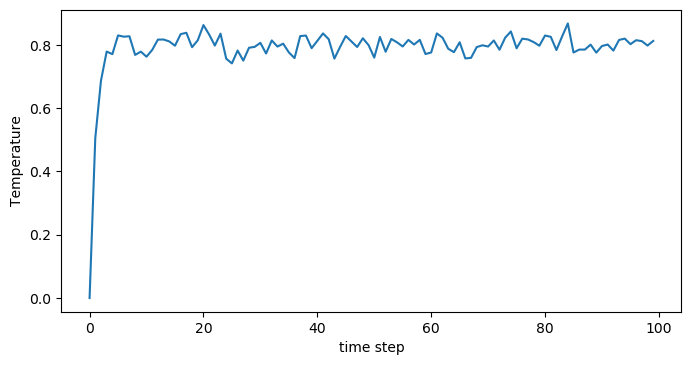

In [29]:
pyplot.figure(figsize=(8,4), dpi=100)
pyplot.plot(data[:,7])
pyplot.xlabel('time step')
pyplot.ylabel('Temperature')

**Tips on handling the ASE atoms object**   
Below are a couple of examples how to extract information from the atoms object.

In [30]:
at_configuration=ase.io.read("system.extxyz") # read atoms objects from file
box=at_configuration.get_cell() # simulation box parameters (3*3 matrix)
vol=at_configuration.get_volume() # volume of the simulation box
pos=at_configuration.get_positions() # atomic coordinates
N=len(at_configuration) # number of atoms
at_type=at_configuration.get_chemical_symbols() # atom_type of each atom

ASE provides several tools to analyse structural properties of configurations, if necessary modules are loaded (``from ase.geometry.analysis import Analysis``) e.g. to calculate radial distribution functions. For further help on how to use these features, check the manual.

## 9. Minimal working example

Below is a minimal example on performing a short MD simulation on a the NVT ensemple, using one-component Lennard-Jones. 

In [2]:
import hoomd
from hoomd import md
hoomd.context.initialize('--mode=cpu');

# Create a 10x10x10 simple cubic lattice of particles with type name A
hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=2.0, type_name='A'), n=10)

# Specify Lennard-Jones interactions between particle pairs
nl = md.nlist.cell()
lj = md.pair.lj(r_cut=3.0, nlist=nl)
lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)

# Integrate at constant temperature
md.integrate.mode_standard(dt=0.005)
hoomd.md.integrate.langevin(group=hoomd.group.all(), kT=1.0, seed=4)

# Run for 10,000 time steps
hoomd.run(10e3)

HOOMD-blue v2.8.0-2-gff981a78f DOUBLE HPMC_MIXED SSE SSE2 SSE3 SSE4_1 
Compiled: 15/11/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 1000 particles
notice(2): integrate.langevin/bd is using specified gamma values
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 1000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors exclude

## Computing a radial distribution function

This is a function (taken from the CH273 module) which computes the *g(r)*. Said function takes in input the following arguments: 
* **r**   = a numpy array containing the positions of all the particles
* **S**   = the length of the box (which is assumed to be square/cubic in 2/3D !!)
* **dr**  = the resolution in r. The smaller this value, the greater the resolution
* **dim** = the dimensionality of the system (2 or 3 D)

and can be call in this fashion: `rad_py, g_r_py = py_rdf(n_data, length, res_dr, 2)` so as to store *r* and *g(r)* into the `rad_py` and `g_r_py` arrays, respectively.

In [37]:
def py_rdf(r, S, dr, dim):
    from numpy import zeros, sqrt, where, pi, mean, arange, histogram, absolute
    num_particles  = len(r)
    rMax           = S/2.0;
    edges          = arange(0., rMax + dr, dr)
    num_increments = len(edges) - 1
    g              = zeros(num_increments)
    radii          = zeros(num_increments)
    numberDensity  = len(r) / S**dim

    # Compute pairwise correlation for each particle
    for index in range(num_particles):

        d = 0.0
        for i in range(dim):
            dp = absolute(r[index,i] - r[:,i])
            mask = dp>S/2.0
            dp[mask] = S - dp[mask]
            d += dp*dp

        d = sqrt(d)
        d[index] = 2 * rMax

        (result, bins) = histogram(d, bins=edges, density=False)
        g += result

    g = g/(num_particles * numberDensity)

    # Normalize the g(r) dividing by the g(r) of an ideal gas - in 2D!
    if dim == 2:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (2.0 * pi * (rOuter-rInner)* radii[i])
    
    # Needed to compute the 3D g(r) (blue box)
    # Normalize the g(r) divinding by the g(r) of an ideal gas - in 3D!
    if dim == 3:
        for i in range(num_increments):
            radii[i] = (edges[i] + edges[i+1]) / 2.
            rOuter = edges[i + 1]
            rInner = edges[i]
            g[i] = g[i] / (4.0 * pi * (rOuter-rInner)* radii[i] * radii[i] )

    return (radii, g)